# Analysis and Insights of 2019 NYC Airbnb data

## Project Objectives.
- Clean up the dataset for proper use with analysis and ML
- Conduct AB Testing to see whether hosts with reviews over a certain threshold garner more bookings
- Create a regression or classification model that determines places listings or hosts within different tiers for how much bookings they get


In [4]:
# for mandatory data cleaning and manipulation where necessary
import pandas as pd
import numpy as np

# for visualizing data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme()

# for probability distributions and performing statistical analysis
import scipy.stats as stats

# for estimating statistical models
import statsmodels.stats.api as sms

# for creating a decision tree model for classifying how popular each host is
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# rounding values where an appropriate whole value is needed at all times
from math import ceil

In [5]:
# load in dataset
df = pd.read_csv('data/AB_NYC_2019.csv')
print(df.shape)
df.head()

(48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## Description of attributes
- id: A unique identifier for each Airbnb listing.
- name: The name or title given to the Airbnb listing by the host.
- host_id: A unique identifier for the host or owner of the Airbnb listing.
- host_name: The name of the host or owner of the Airbnb listing.
- neighbourhood_group: The broader neighborhood or borough where the listing is located (e.g., Brooklyn, Manhattan).
- neighbourhood: The specific neighborhood within the borough where the listing is located (e.g., Kensington, Midtown, Harlem).
- latitude: The latitude coordinate of the listing's location.
- longitude: The longitude coordinate of the listing's location.
- room_type: The type of accommodation offered, such as an entire home/apartment or a private room.
- price: The nightly price (in US dollars) for the listing.
- minimum_nights: The minimum number of nights required for a booking at this listing.
- number_of_reviews: The total number of reviews the listing has received from guests.
- last_review: The date of the most recent review left for the listing.
- reviews_per_month: The average number of reviews the listing receives per month.
- calculated_host_listings_count: The number of listings the host has on Airbnb, - calculated by the platform.
- availability_365: The number of days the listing is available for booking in the next 365 days.

In [6]:
# check what columns I really need
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [7]:
# check for null values as well
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

### Based on info from the columns, there doesn't appear to be data that needs to be replaced with any form of mean, median, or mode data. 
### Also the last review and reviews per month columns have a justifiable reason to be null 
- Probably will replace with certain default values like the earliest date possible and also 0 reviews.
- This will still isolate them as the earliest date values and the 0s will be the most extreme outliers aka null values

In [8]:
df[df.name.isnull()].head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
2854,1615764,NaN,6676776,Peter,Manhattan,Battery Park City,40.71239,-74.01620,Entire home/apt,400,1000,0,NaN,NaN,1,362
3703,2232600,NaN,11395220,Anna,Manhattan,East Village,40.73215,-73.98821,Entire home/apt,200,1,28,2015-06-08,0.45,1,341
5775,4209595,NaN,20700823,Jesse,Manhattan,Greenwich Village,40.73473,-73.99244,Entire home/apt,225,1,1,2015-01-01,0.02,1,0
5975,4370230,NaN,22686810,Michaël,Manhattan,Nolita,40.72046,-73.99550,Entire home/apt,215,7,5,2016-01-02,0.09,1,0
6269,4581788,NaN,21600904,Lucie,Brooklyn,Williamsburg,40.71370,-73.94378,Private room,150,1,0,NaN,NaN,1,0


In [9]:
# fixing the name column first
df.name.fillna('Unknown',inplace=True)
df[df.name.str.contains('Unknown')].shape

(16, 16)

In [10]:
# fix the null host names
df['host_name'].fillna('Not available', inplace=True)
df[df.host_name.str.contains('Not available')].shape

(21, 16)

In [11]:
# the last review columns are a bunch of dates but something that will matter is to check if its stored as datetime object which is what we want
df['last_review'].apply(type)

0          <class 'str'>
1          <class 'str'>
2        <class 'float'>
3          <class 'str'>
4          <class 'str'>
              ...       
48890    <class 'float'>
48891    <class 'float'>
48892    <class 'float'>
48893    <class 'float'>
48894    <class 'float'>
Name: last_review, Length: 48895, dtype: object

In [12]:
# give the null last review dates a date value not too far off from all other values.
# This will be helpful for identifying trends and also knowing what values are clearly outliers in visualizations or sneak peeks of the data
df['last_review'].fillna('1950-01-01', inplace=True)
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1950-01-01,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [13]:
# the date is stored as a string with null values being stored as float values
df['last_review'] = pd.to_datetime(df['last_review'])
print(df['last_review'][:3].apply(type))
df.head()


0    <class 'pandas._libs.tslibs.timestamps.Timesta...
1    <class 'pandas._libs.tslibs.timestamps.Timesta...
2    <class 'pandas._libs.tslibs.timestamps.Timesta...
Name: last_review, dtype: object


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1950-01-01,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [14]:
# fix the reviews per month column
df.reviews_per_month.fillna(0, inplace=True)
df.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1950-01-01,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [15]:
# TODO: Seems that I need to dive deeper into the dataset and remove rows
# where there's no more availability for the listing for the next 365 days

### Now that the issue with null values have been cleared up. We want to do a little bit of Exploratory Data Analysis to get more insight into how the different columns look in relation to the dispersion of data points

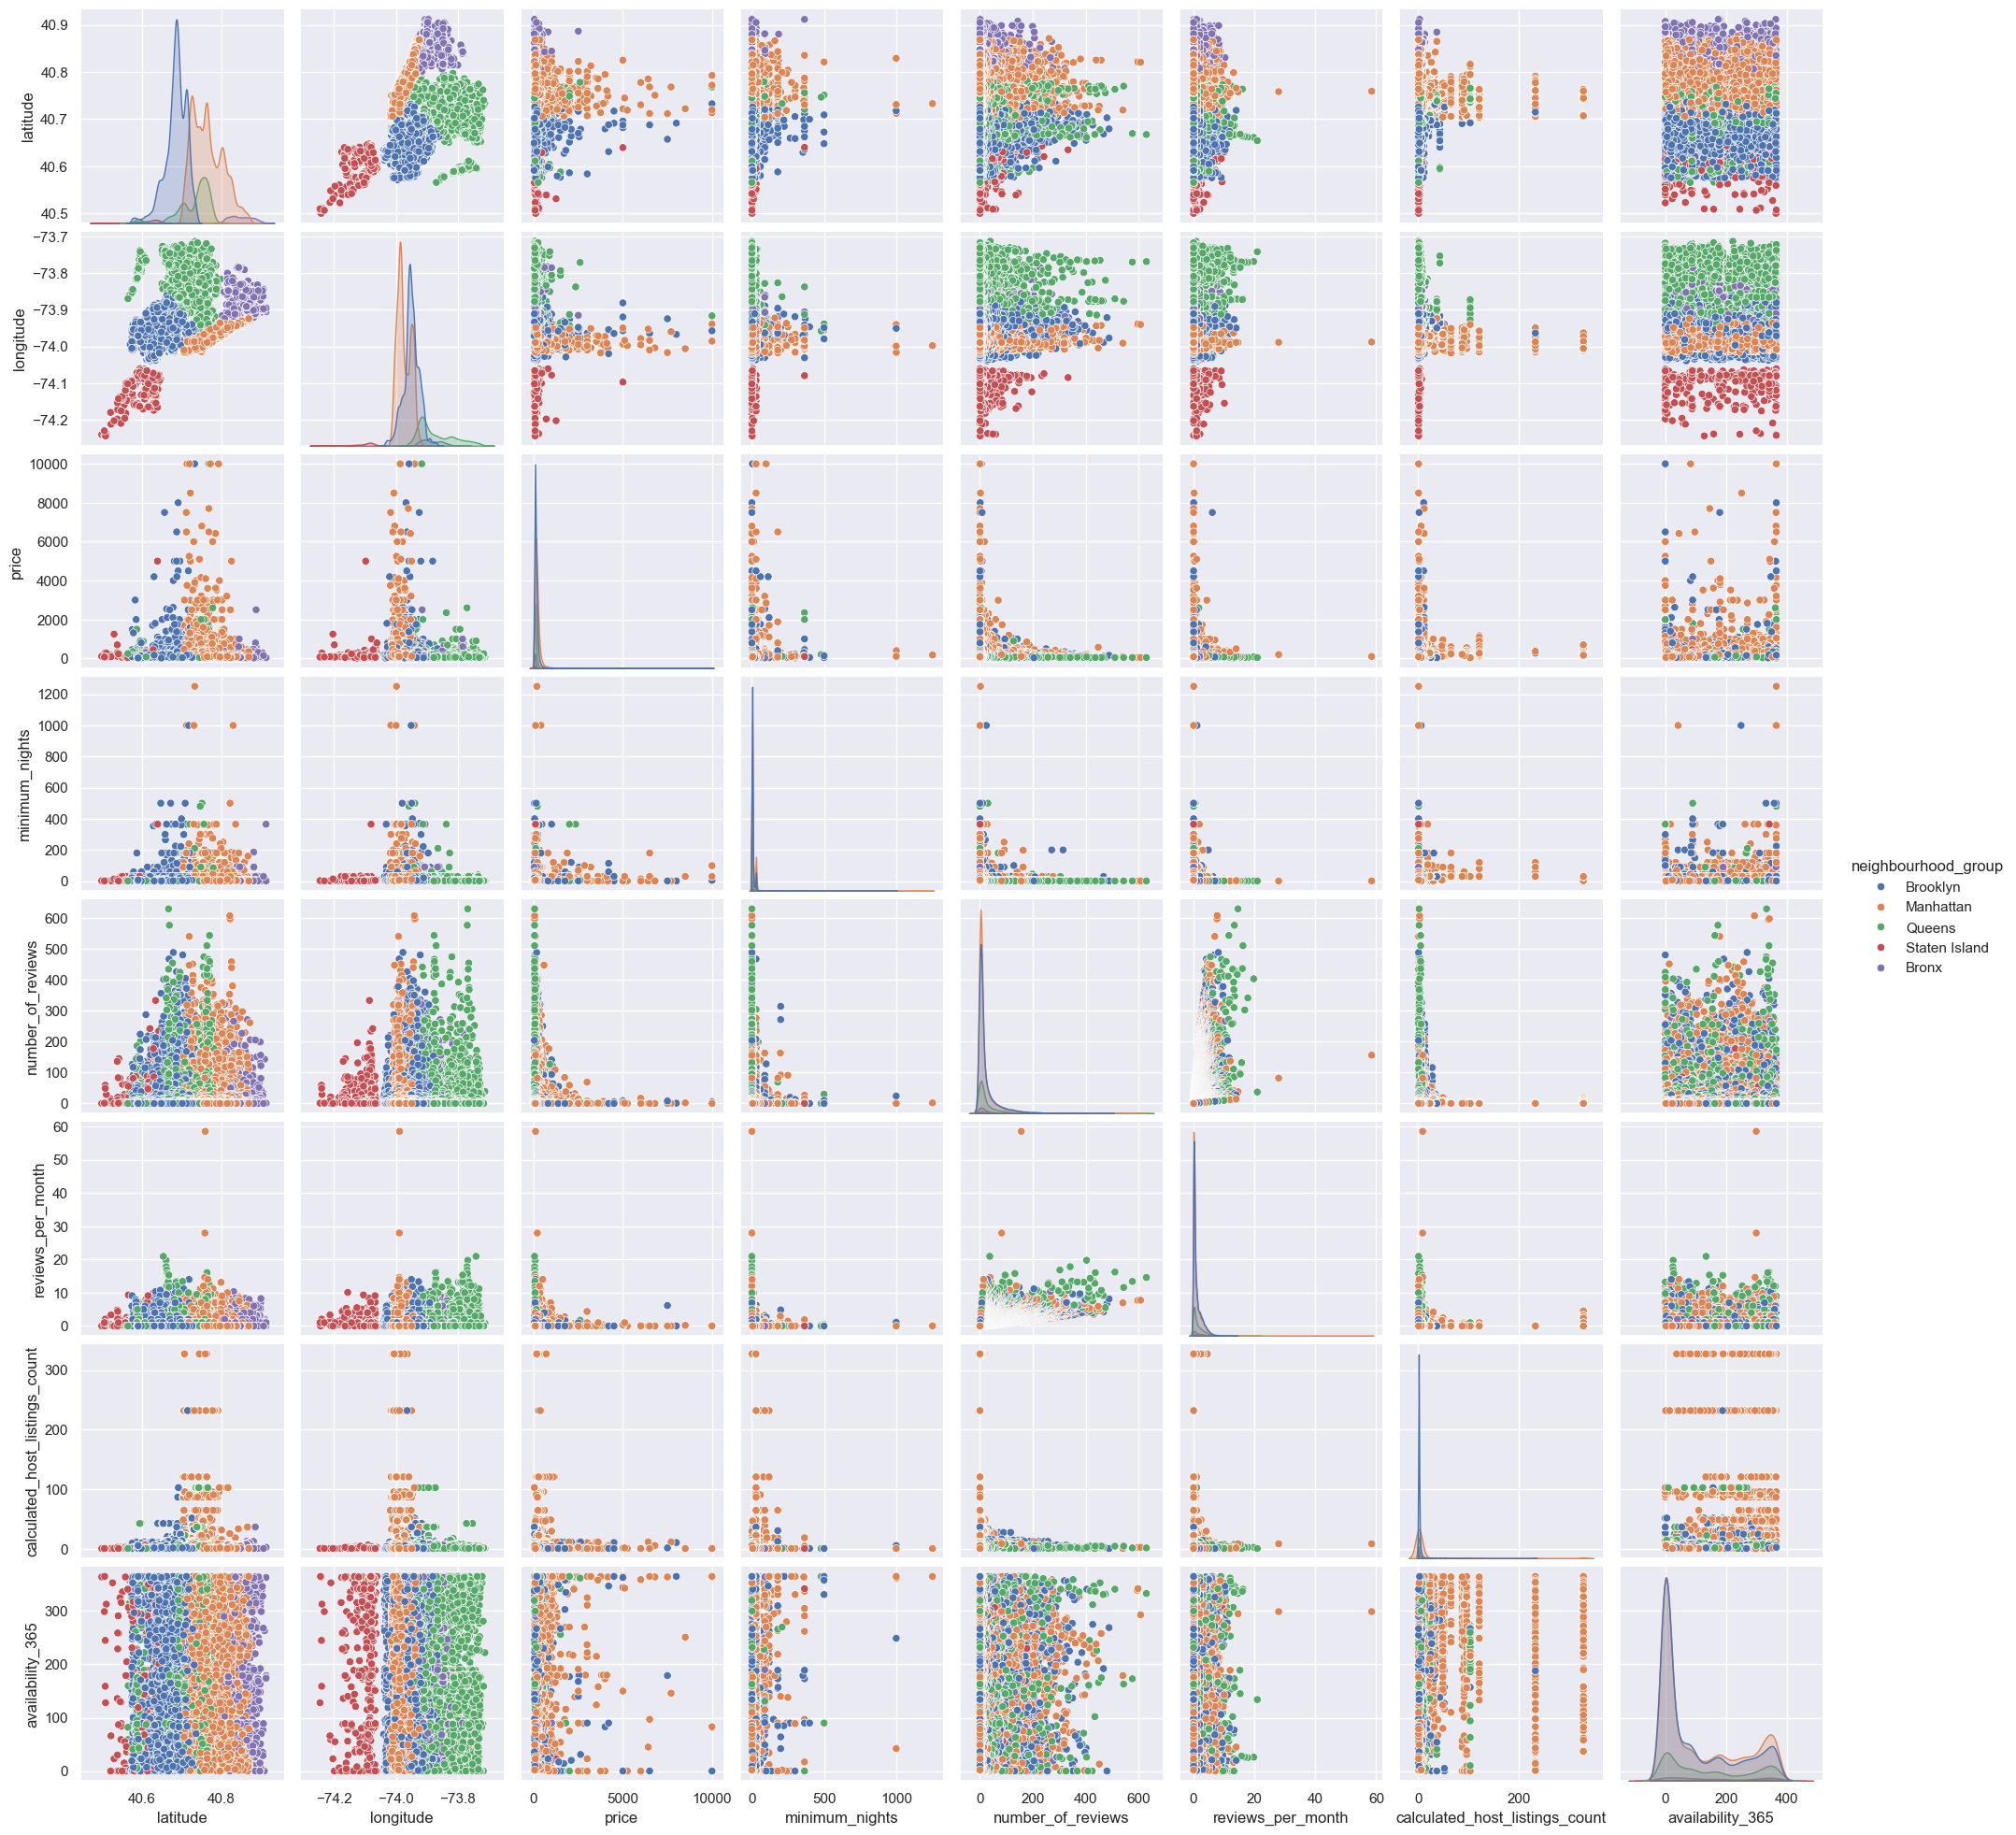

In [16]:
selected_features = df[['neighbourhood_group','latitude', 'longitude', 'price',
       'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365']]

sns.pairplot(data=selected_features, hue='neighbourhood_group')

## AB Testing
### Now that we have cleaned up the dataset and also been given a good view on the distribution of values between the quantitative variables and each neighborhood group, we'll move to AB testing

### Specifically we want to see if numbers of reviews over a certain threshold leads to more bookings for a host 

In [17]:
# first we need to look a bit more into the data to see the max and minimums for the numbers of reviews and bookings for a listing
print(f'Max reviews: {df.number_of_reviews.max()}\nMax reviews per month: {df.reviews_per_month.max()}')

Max reviews: 629
Max reviews per month: 58.5


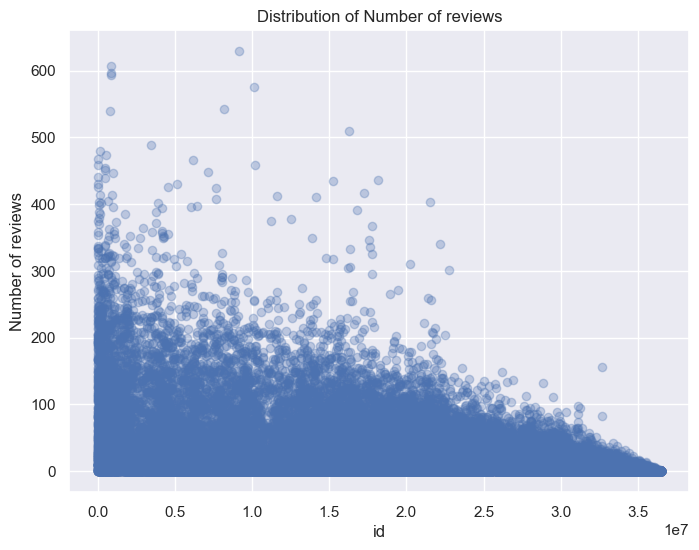

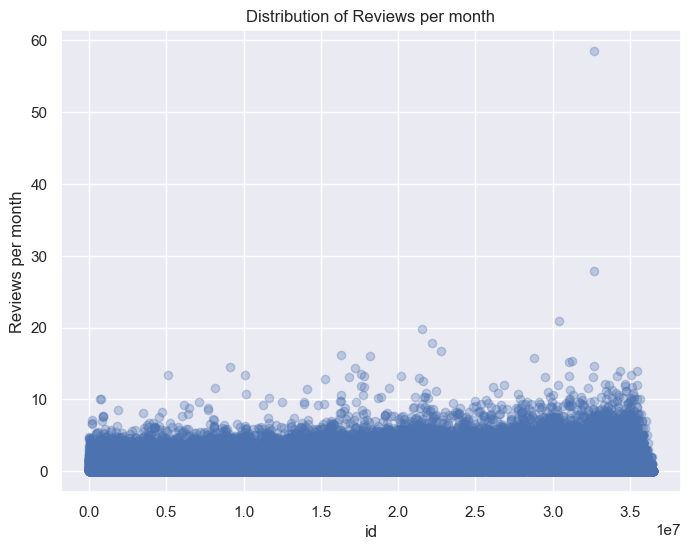

In [18]:

def plot_column(df, column_name, alpha=0.8):
    """
    Creates a line plot for the given column against the 'id' column.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        column_name (str): The name of the column to be plotted.
        alpha (float, optional): The transparency value for the line plot. Default is 0.8.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(df['id'], df[column_name], alpha=alpha)
    ax.set_xlabel('id')
    ax.set_ylabel(column_name.capitalize().replace('_', ' '))
    ax.set_title(f'Distribution of {column_name.replace("_", " ").capitalize()}')
    plt.show()

# to go even deeper, we'll conduct an EDA just to get an idea of the distribution of max reviews and reviews per month
reviews_check = df[['id', 'number_of_reviews', 'reviews_per_month']]

# Plot for 'number_of_reviews'
plot_column(reviews_check, 'number_of_reviews', alpha=0.3)

# Plot for 'reviews_per_month'
plot_column(reviews_check, 'reviews_per_month', alpha=0.3)

In [19]:
# shows that some hosts have multiple listings
print(df.shape)
print(df.host_id.unique().shape)

(48895, 16)
(37457,)


In [20]:
# TODO: I have to perform some form of aggregation and grouping by unique host_ids
# the point is to see how many reviews they have

In [21]:
# checking more statistics on each host to determine what I perform my AB Test on
host_df = df.groupby('host_id')['price'].agg(['mean', 'min', 'max', 'count', 'std']).reset_index()
host_df.sort_values(by='mean', ascending=True)[150:160]


,host_id,mean,min,max,count,std
36456,258671946,27.000000,27,27,1,NaN
15312,17927814,27.000000,27,27,1,NaN
20879,35510045,27.000000,27,27,1,NaN
32441,161743285,27.000000,27,27,1,NaN
25222,57398859,27.000000,27,27,1,NaN
35428,232778333,27.000000,25,29,2,2.828427
28955,101970559,27.166667,0,50,6,22.613418
7454,4878363,27.500000,25,30,2,3.535534
31908,153371127,27.500000,27,28,2,0.707107
31504,145242566,27.500000,25,30,2,3.535534


In [22]:
# checking more statistics on each host to determine what I perform my AB Test on
host_df1 = df.groupby('host_id')['price'].agg(['mean', 'min', 'max', 'count', 'std']).reset_index()
host_df1.sort_values(by='mean', ascending=False)

,host_id,mean,min,max,count,std
26778,72390391,10000.0,10000,10000,1,NaN
16313,20582832,10000.0,10000,10000,1,NaN
7693,5143901,10000.0,10000,10000,1,NaN
6985,4382127,9999.0,9999,9999,1,NaN
6315,3906464,9999.0,9999,9999,1,NaN
...,...,...,...,...,...,...
33762,197169969,10.0,10,10,1,NaN
34080,205820814,10.0,10,10,1,NaN
37092,268138154,10.0,10,10,1,NaN
11495,10132166,0.0,0,0,1,NaN


In [23]:
# when we check both, we see that we need to possibly remove a few hosts
# this is because as they have listings with no price.
# We may also have a limit behind it as a 10 dollar listing isnt realistic

print(df.shape)
df.drop(df[df['price'] < 1].index, inplace = True)
print(df.shape)

(48895, 16)
(48884, 16)


In [24]:
# looking to clean the data for ab testing even more by making the availability constant as that can affect number of reviews
df[(df['availability_365'] >= 243) & (df['neighbourhood_group'] == 'Manhattan')].shape

(5130, 16)

In [25]:
# now we have a good enough size for what we are looking for so we will create the testing dataframe
testing_df = df[(df['availability_365'] >= 243) & (df['neighbourhood_group'] == 'Manhattan')]
testing_df.shape


(5130, 16)

### cleaned dataframe statistics

In [26]:
# for the cleaned dataframe
testing_df.number_of_reviews.agg(['mean', 'median'])
price_filter = (testing_df['price'] >= 50) & (testing_df['price'] <= 150)
filtered_df = testing_df[price_filter]

# Calculate the mean and median number of reviews for the filtered DataFrame
filtered_df['number_of_reviews'].agg(['mean', 'median'])

mean      32.6952
median     8.0000
Name: number_of_reviews, dtype: float64

In [27]:
# for the cleaned dataframe
testing_df.number_of_reviews.agg(['mean', 'median'])
price_filter_1 = (testing_df['price'] > 150) & (testing_df['price'] <= 300)
filtered_df = testing_df[price_filter_1]

# Calculate the mean and median number of reviews for the filtered DataFrame
filtered_df['number_of_reviews'].agg(['mean', 'median'])

mean      20.708805
median     2.000000
Name: number_of_reviews, dtype: float64

### original dataframe statistics

In [37]:
df.number_of_reviews.agg(['mean', 'median'])
price_filter_2 = (df['price'] >= 50) & (df['price'] <= 150)
filtered_df2 = df[price_filter_2]

# Calculate the mean and median number of reviews for the filtered DataFrame
filtered_df2['number_of_reviews'].agg(['mean', 'median'])

mean      25.601901
median     6.000000
Name: number_of_reviews, dtype: float64

In [38]:
df.number_of_reviews.agg(['mean', 'median'])
price_filter_3 = (df['price'] > 150) & (df['price'] <= 300)
filtered_df3 = df[price_filter_3]

# Calculate the mean and median number of reviews for the filtered DataFrame
filtered_df3['number_of_reviews'].agg(['mean', 'median'])

mean      21.510491
median     5.000000
Name: number_of_reviews, dtype: float64

## Testing to see if lower priced listings are more likely to attract more reviews vs higher priced listings
### We primarily want to see this between two common price ranges for listings($50-$150 and $151-$300)

### Currently, there are on average

In [41]:
# setting up the effective size and required sample size needed for testing based on the minimum difference of improvement we are checking for
# mean number of reviews for the price range between 151 and 300 including 151
effect_size = sms.proportion_effectsize((21.510491/100), .25)

required_n = sms.NormalIndPower().solve_power(
    effect_size=effect_size,
    power=.80,
    alpha=.05,
    ratio=1,
)

required_n = ceil(required_n)

print(f'Effective size is: {effect_size} and required n(sample size) is {required_n}')

Effective size is: -0.08265173637183065 and required n(sample size) is 2298


### now we need to check that there are no users sampled multiple times.
### this means host_ids that have multiple listings will be removed

In [43]:
host_id_counts = testing_df['host_id'].value_counts()

multi_users = host_id_counts[host_id_counts > 1].count()

multi_users

461